In [413]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef
import sunspots.sunspots as sunspots

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

In [414]:
def read_deterministic_forecast_cdf(cr):
    ### Reads in deterministic forecast runs
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\deterministic_forecasts\\deterministic_CR{cr}.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    df = loaded_ds.sel().to_dataframe()

    return df

def compute_roc_score(roc_curve):
    """
    Computes integrates area under ROC curve using scipy quad returning integrated area as the ROC score

    Parameters:
    - roc_curve (list): list of tuples which each contain the hit rate and false alarm rate calculated at different thresholds

    Returns:
    - result (float): ROC Score calculated as the integrated area under ROC curve
    """

    # Unpack and prepare roc curve data
    y,x = zip(*roc_curve)

    x = np.array([xx for xx in x])
    y = np.array([yy for yy in y])

    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)

    nan_mask = np.logical_and(nan_mask_x, nan_mask_y)

    x = x[nan_mask]
    y = y[nan_mask]

    # Interpolate the curve
    interp_function = scipy.interpolate.interp1d(x, y, kind='linear')

    # Define the integration limits
    a = min(x)
    b = max(x)

    # Perform the integration
    result, error = integrate.quad(interp_function, a, b)

    return result


def interpolate_and_resample(observed_data_index, forecast_index, forecast):
    
    # This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep
    Int = scipy.interpolate.CubicSpline(forecast_index, forecast)

    interpolated_forecast_output = Int(observed_data_index)

    return interpolated_forecast_output


def perturb_longitude(long_pert_dt, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)


def gen_ranked_ensemble(ensemble_members, omni_data): 

    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    omni_chunk = omni_data.loc[pd.to_datetime(ensemble_members[0].index[0]):pd.to_datetime(ensemble_members[0].index[-1])]
 
    omni_chunk = omni_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time step
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(observed_data_index = omni_chunk.index, forecast_index=vsw.index, forecast=vsw['vsw'])
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    ranked_forecast_boolean = np.array([vsw < omni_chunk['V'] for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)
    
    return summed_ranks

def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
        
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq_alt = 0 
    
    for i in range(ensemble_size):
        
        chi_sq_alt += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq_alt = chi_sq_alt*np.sum(ensemble_hist)*(ensemble_size+1)

    return chi_sq_alt

def chi_rank_over_longitude_range(ensemble_sets, long_min, long_max, increments, ensemble_size):

    rng = np.random.default_rng()
    
    carrington_rotation = 27.2753*u.day
    long_pert_var_list = np.linspace(long_min, long_max, increments) # Define range of longitude variances to perturb by
    chi_square_across_longitude = np.ones(increments)

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, long_pert_var in enumerate(long_pert_var_list):
        
        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
        ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

        for ensemble_members in ensemble_sets:

            lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members

            # Loop through each ensemble member to perturb in longitude
            for df in ensemble_members:
                
                # Randomly generate perturbation amount
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day # Convert perturbation amount to a unit of days

                # perturb ensemble member 
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
                lp_ensemble_members.append(shifted_df)
            
            # rank ensemble output against data
            ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
            lp_ensemble_sets.append(lp_ensemble_members)
        
        # calculate chi squared for combined rank histograms for time frame
        rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))
        chi_square_across_longitude[i] = rank_chi_square

    return chi_square_across_longitude

def save_chi_arr_to_file(chi_set_list, era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    np.savetxt(fname = fname, X = chi_set_list, delimiter = ',')
    return

def read_in_and_perturb_ensemble(CR_chunk, lat_dev, long_pert_var, omni_data, ensemble_size):
    
    rng = np.random.default_rng()
    carrington_rotation = 27.2753*u.day

    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, ensemble_members in enumerate(ensemble_sets):

        lp_ensemble_members = []

        for df in ensemble_members:

            # Perturb ensemble member in longitude
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

            # resample perturbed ensemble member onto omni data timestep
            Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
            resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
            lp_ensemble_members.append(resampled_shifted_df)
        
        lp_ensemble_sets.append(lp_ensemble_members)

    ## Longitudinally perturbed ensemble members
    combined_lp_ensemble_members = []

    # Create a new list of lists
    for i in range(ensemble_size):
        list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
        combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

    return combined_lp_ensemble_members, combined_data

def get_data_chunks_per_CR(CR_chunk, omni_data):

    carrington_rotation = 27.2753*u.day

    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:
    
        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    return data_chunks

def compute_calibration_curve(ensemble_members, observed_data, event_threshold, num_bins):
    
    # generate probabiistic forecast from ensemble set
    probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
                                                            threshold=event_threshold, ensemble_size=len(ensemble_members))
    
    y_prob = probabilistic_forecast
    # binarised data by event threshold
    y_true = eef.generate_catagorical_forecast(forecast=observed_data, threshold=event_threshold)

    # generate calibration curve using scikitlearn fuction - 'quantile' qwarg means bins contain equal data points
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = 'uniform')

    return (prob_true, prob_pred)

def save_brier_scores_to_file(brier_scores, era_key, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = brier_scores, delimiter = ',')
    return

def save_roc_scores_to_file(roc_scores, era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    np.savetxt(fname = fname, X = roc_scores, delimiter = ',')
    return

def save_calibration_curves_to_file(calibrations_grid, era_key, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\calibration_curves_{era_key}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = calibrations_grid, delimiter = ',')
    return

def read_brier_scores_file(era_key, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_rank_hist_file(era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_ROC_scores_file(era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_calibration_curves_file(era_key, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\calibration_curves_{era_key}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')



#### Read in and prepare OMNI data

In [415]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

#### Perturbation scheme impact on timeseries

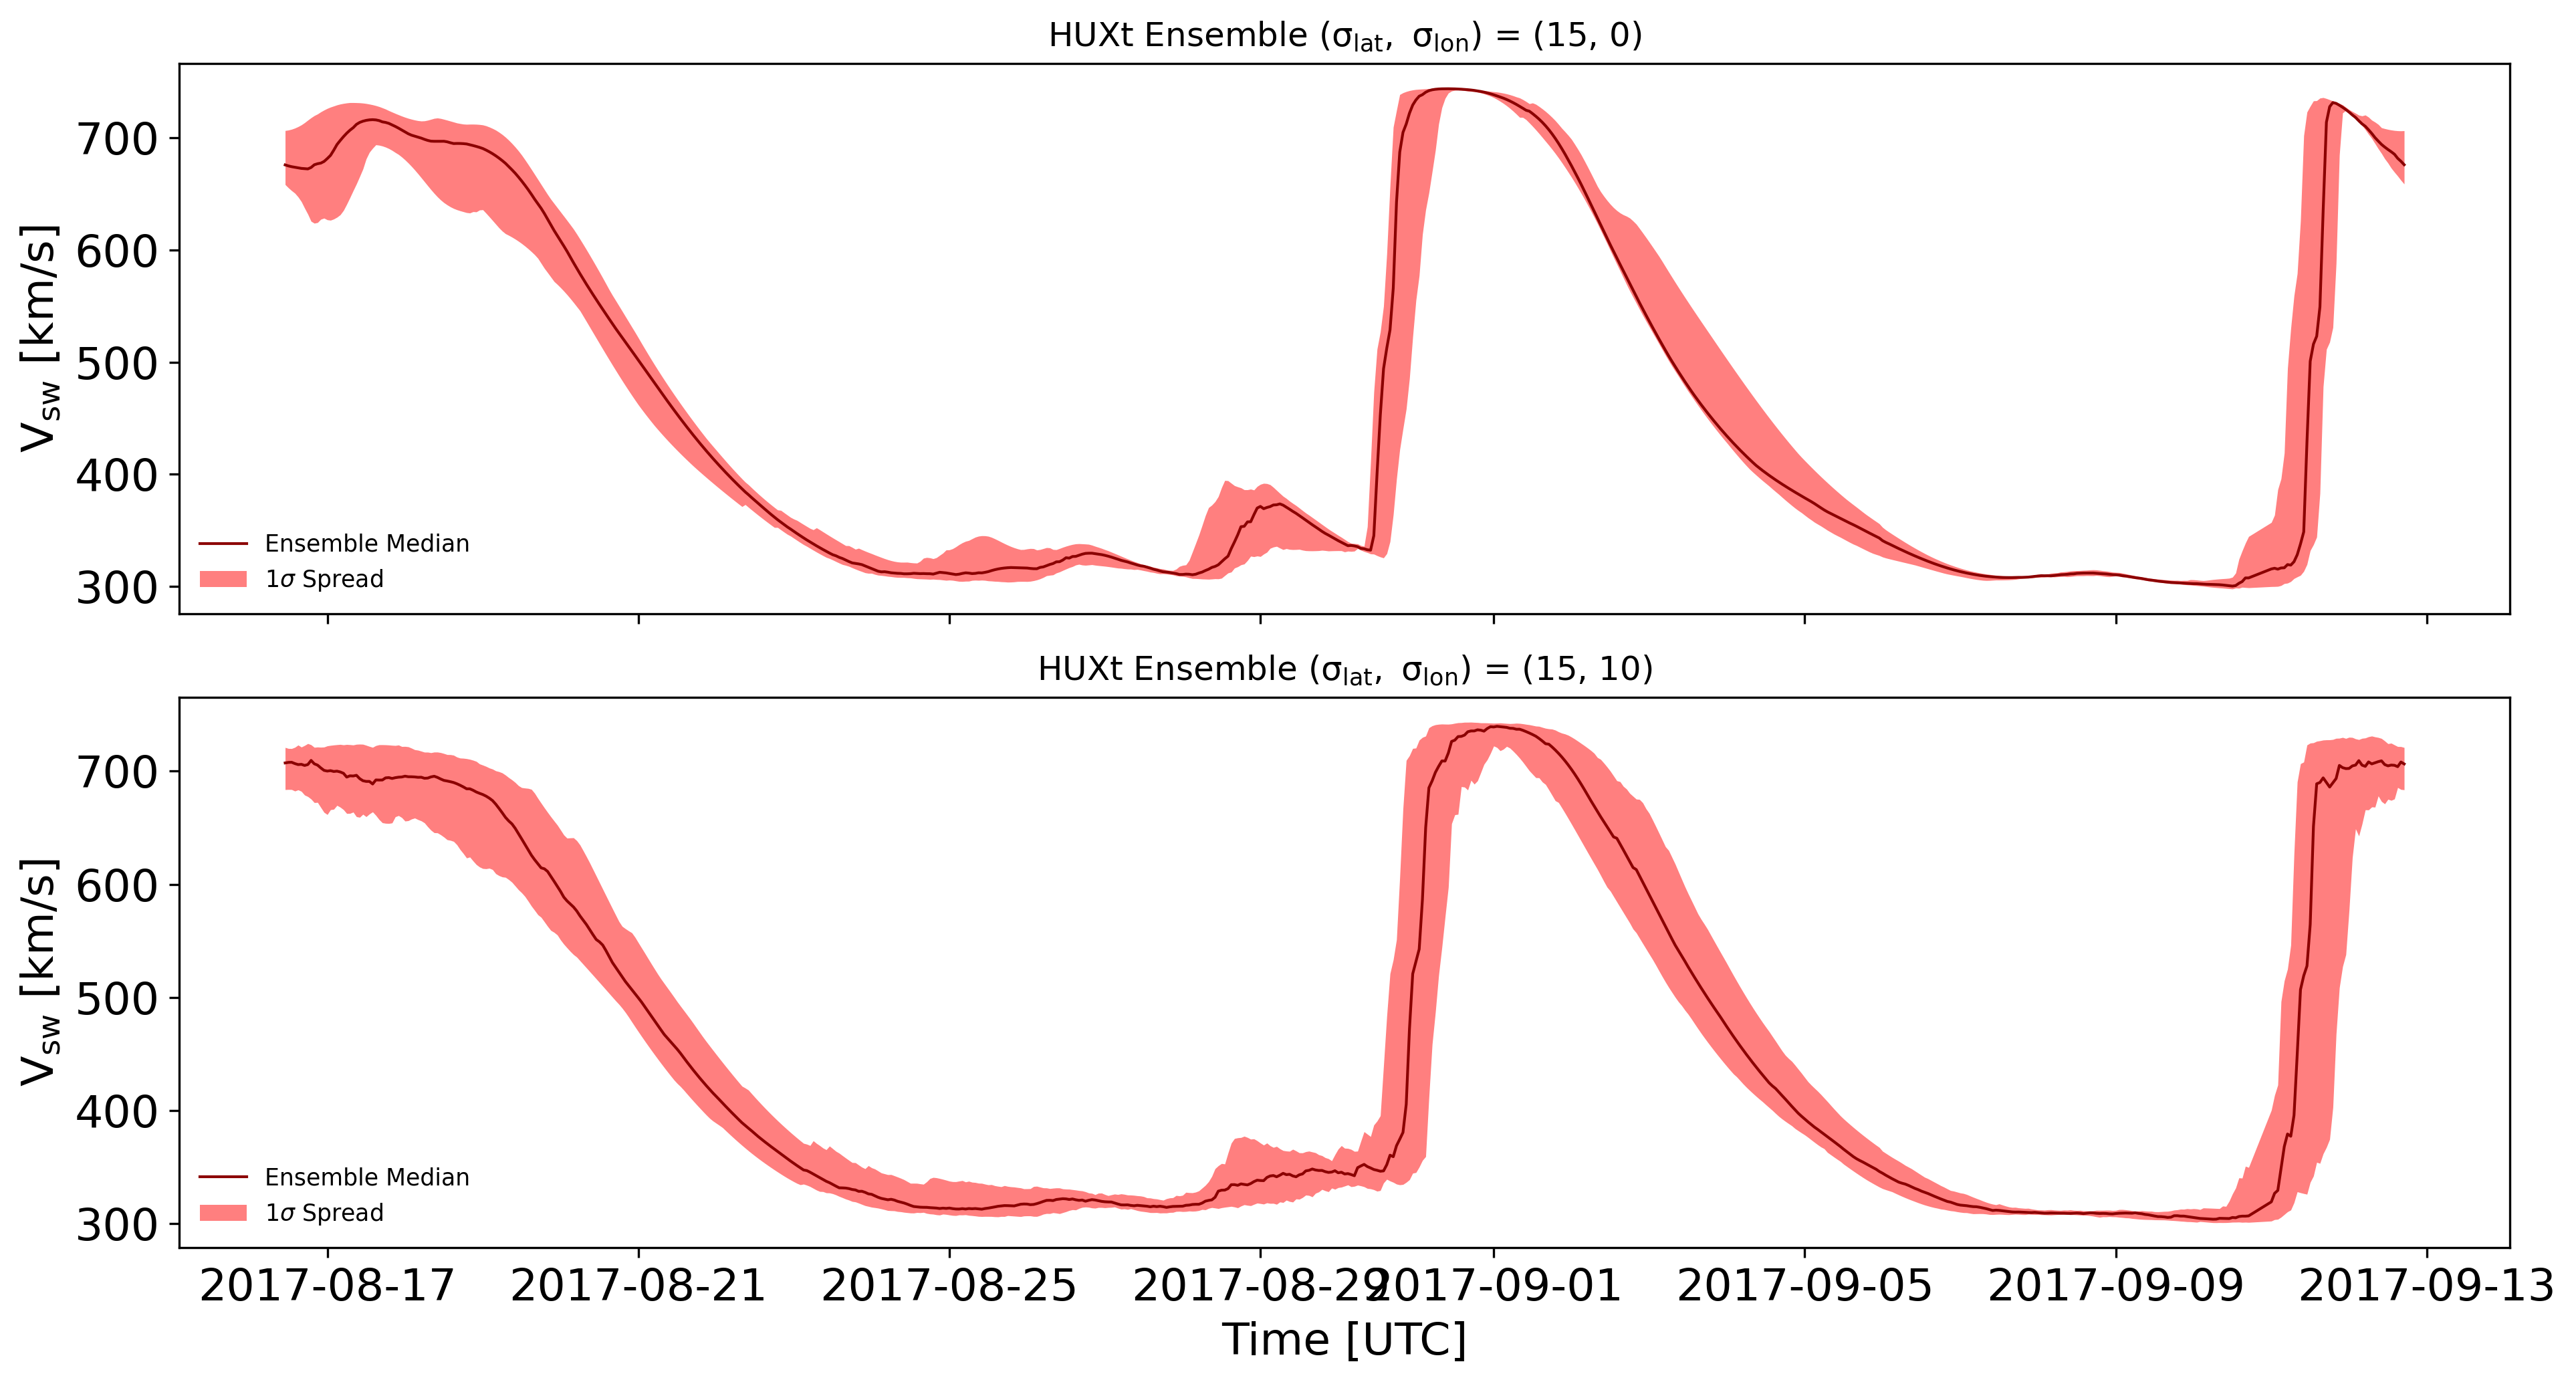

In [416]:
lat_dev = 15
long_dev = 0
ensemble_size = 100
CR_chunk = [2194]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

lp_lat_dev = 15
lp_long_dev = 10
lp_ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lp_lat_dev, long_pert_var=lp_long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

max_speed = np.percentile(ensemble_members, 34.1, axis = 0)
min_speed = np.percentile(ensemble_members, 100-34.1, axis = 0)

lp_max_speed = np.percentile(lp_ensemble_members, 34.1, axis = 0)
lp_min_speed = np.percentile(lp_ensemble_members, 100-34.1, axis = 0)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (13,7), dpi = 300, sharex=True)

axes[0].fill_between(ensemble_members[0].index, y1 = min_speed, y2 = max_speed, label = r'1$\sigma$ Spread', color = 'red', alpha = 0.5, lw = 0)
axes[0].plot(ensemble_members[0].index, np.median(ensemble_members,axis=0), color = 'darkred', lw = 1, label = 'Ensemble Median')
axes[0].set_title(f'HUXt Ensemble ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev})')
axes[0].set_ylabel(r'$\mathrm{V_{sw}}$ [km/s]')
axes[0].legend(frameon = False, fontsize = 'small')

axes[1].fill_between(lp_ensemble_members[0].index, y1 = lp_min_speed, y2 = lp_max_speed, label = '1$\sigma$ Spread', color = 'red', alpha = 0.5, lw = 0)
axes[1].plot(lp_ensemble_members[0].index, np.median(lp_ensemble_members,axis=0), color = 'darkred', lw = 1, label = 'Ensemble Median')
axes[1].set_title(f'HUXt Ensemble ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lp_lat_dev}, {lp_long_dev})')
axes[1].set_xlabel('Time [UTC]')
axes[1].set_ylabel(r'$\mathrm{V_{sw}}$ [km/s]')
#axes[1].set_xticklabels(, rotation = 45)
axes[1].legend(frameon = False, fontsize = 'small')

fname = 'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\perturbation_impact.svg'
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')

plt.tight_layout()
plt.show()

#### Getting Carrington rotations of Solar min, Solar max, and Solar intermediate for solar cycle 24

In [417]:
# Load sunspot number data
filepath = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\SN_m_tot_V2.0.csv'
ssn = sunspots.LoadSSN(filepath = filepath)

# Start and end date of solar cycle 24
solar_start = datetime.date.fromisoformat('2008-12-01')
solar_end = datetime.date.fromisoformat('2020-01-01')

# Isolate solar cycle 24 in sunspot number data
solar_cycle_24 = ssn.set_index('datetime')
solar_cycle_24 = solar_cycle_24[solar_start:solar_end]

# isolate solar min/max/intermediate values by solar activity index
solar_min_mask = solar_cycle_24['sai'] < 0.33
solar_min_mask = solar_min_mask[solar_min_mask!=0]

solar_max_mask = solar_cycle_24['sai']  > 0.66
solar_max_mask = solar_max_mask[solar_max_mask!=0]

solar_other_mask = (solar_cycle_24['sai'] >= 0.33) & (solar_cycle_24['sai'] <= 0.66)
solar_other_mask = solar_other_mask[solar_other_mask!=0]

# get carrington rotations of each section of solar cycle
solar_min_CR_list = np.unique(np.round(carrington_rotation_number(solar_min_mask.index),0).astype(int))
solar_max_CR_list = np.unique(np.round(carrington_rotation_number(solar_max_mask.index),0).astype(int))
solar_other_CR_list = np.unique(np.round(carrington_rotation_number(solar_other_mask.index),0).astype(int))

# create dictionary for use later
solar_era_dict = {'min':solar_min_CR_list, 'other':solar_other_CR_list, 'max':solar_max_CR_list}
CR_chunk_key = ['min', 'other', 'max']

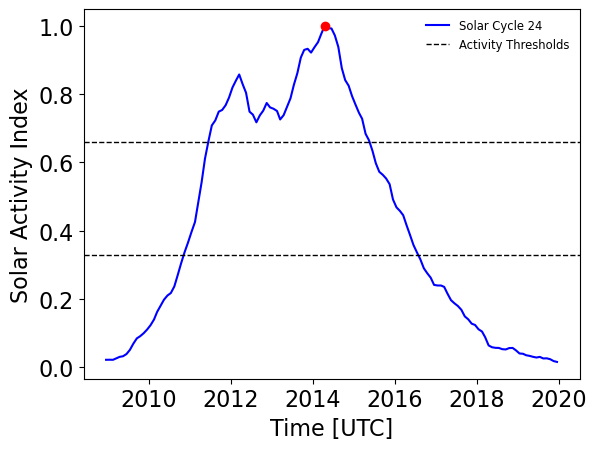

In [483]:
solar_max_peak_idx = np.argwhere(solar_cycle_24['sai'].to_numpy() == 1)

plt.plot(solar_cycle_24['sai'], label = 'Solar Cycle 24', color = 'blue')
plt.plot(solar_cycle_24.index[solar_max_peak_idx], 1, marker = 'o', color = 'red')
plt.axhline(0.33, lw = 1, linestyle = '--', color = 'black', label = 'Activity Thresholds')
plt.axhline(0.66, lw = 1, linestyle = '--', color = 'black')
plt.legend(frameon = False, loc = 'upper right', fontsize = 'small')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Activity Index')
plt.show()


In [515]:
# Load sunspot number data
filepath = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\SN_m_tot_V2.0.csv'
ssn = sunspots.LoadSSN(filepath = filepath)

# Start and end date of solar cycle 24
solar_start = datetime.date.fromisoformat('2008-12-01')
solar_end = datetime.date.fromisoformat('2020-01-01')

# Isolate solar cycle 24 in sunspot number data
solar_cycle_24 = ssn.set_index('datetime')
solar_cycle_24 = solar_cycle_24[solar_start:solar_end]

solar_max_peak_idx = np.argwhere(solar_cycle_24['sai'].to_numpy() == 1)[0][0]

sc_24_rise = solar_cycle_24.iloc[:solar_max_peak_idx+1]
sc_24_fall = solar_cycle_24.iloc[solar_max_peak_idx-1:]

def get_min_max_other(df_sai):

    # isolate solar min/max/intermediate values by solar activity index
    solar_min_mask = df_sai['sai'] < 0.33
    solar_min_mask = solar_min_mask[solar_min_mask!=0]

    solar_max_mask = df_sai['sai']  > 0.66
    solar_max_mask = solar_max_mask[solar_max_mask!=0]

    solar_other_mask = (df_sai['sai'] >= 0.33) & (df_sai['sai'] <= 0.66)
    solar_other_mask = solar_other_mask[solar_other_mask!=0]

    # get carrington rotations of each section of solar cycle
    converted_min_CR_list = np.unique(np.round(carrington_rotation_number(solar_min_mask.index),0).astype(int))
    converted_max_CR_list = np.unique(np.round(carrington_rotation_number(solar_max_mask.index),0).astype(int))
    converted_other_CR_list = np.unique(np.round(carrington_rotation_number(solar_other_mask.index),0).astype(int))

    # get carrington rotations of each section of solar cycle
    solar_min_CR_list = np.arange(np.min(converted_min_CR_list), np.max(converted_min_CR_list))
    solar_max_CR_list = np.arange(np.min(converted_max_CR_list), np.max(converted_max_CR_list))
    solar_other_CR_list = np.arange(np.min(converted_other_CR_list), np.max(converted_other_CR_list))
    
    return solar_min_CR_list, solar_max_CR_list, solar_other_CR_list


solar_min_list = []
solar_max_list = []
solar_other_list = []

for df_ in [sc_24_rise, sc_24_fall]:

    solar_min, solar_max, solar_other = get_min_max_other(df_)
    solar_min_list.append(solar_min)
    solar_max_list.append(solar_max)
    solar_other_list.append(solar_other)


# create dictionary for use later
solar_era_dict = {'min':np.concatenate(solar_min_list), 'other':np.concatenate(solar_other_list), 'max':np.concatenate(solar_max_list)}
CR_chunk_key = ['min', 'other', 'max']

In [522]:
ensemble_size = 100

for key in CR_chunk_key:  

    # Latitude perturbation parameters
    lat_dev_list = [0,5,10,15,20,25,30,35,40]

    CR_chunk = solar_era_dict[key] # List of CR associated with given solar era

    chi_set_list = []

    for lat_dev in lat_dev_list:

        ensemble_sets = [] # List to store each CR ensemble set 

        # Read in ensemble members per CR
        for CR in CR_chunk:
            ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
            ensemble_members = [df.set_index('datetime') for df in ensemble_members]
            ensemble_sets.append(ensemble_members)

        chi_list = chi_rank_over_longitude_range(ensemble_sets=ensemble_sets, long_min = min(lat_dev_list), 
                                                 long_max=max(lat_dev_list), increments=len(lat_dev_list), ensemble_size=ensemble_size)
        chi_set_list.append(chi_list)

    save_chi_arr_to_file(chi_set_list=chi_set_list, era_key=key)

In [523]:

rank_histogram_grids = [read_rank_hist_file(key) for key in CR_chunk_key]


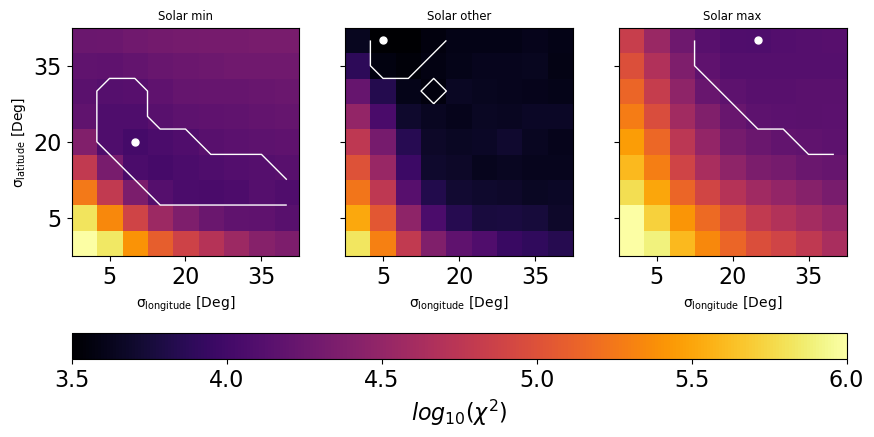

In [538]:

fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i, key in enumerate(CR_chunk_key):

    rank_hist = rank_histogram_grids[i]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3.5, vmax = 6) 

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.05
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')

    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{10^th percentile range}$')
    axes[i].set_title(f'Solar {key}', fontsize = 'small')


axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1,2]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')

#plt.tight_layout()

# fname = 'ChiSquareGrids_MMO.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

#### Looking at the calibration curve of ensembles with best/worse distributed rank histograms

In [525]:
# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 10
ensemble_size = 100
event_threshold = 500

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

In [533]:
np.arange(0,45,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40])

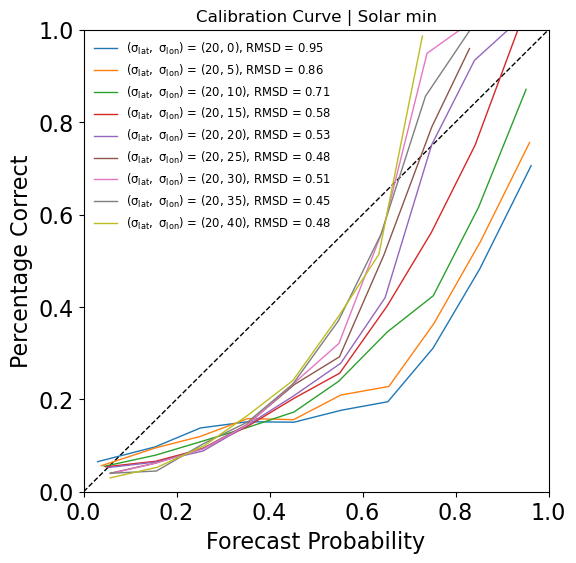

In [543]:
def rmsd_of_cal_curve(cal_curve):

    #compute root mean square deviation from ideal calibration line (the centre diagonal line)
    rmsd = np.sqrt((((cal_curve[0] - cal_curve[1])**2).sum()).mean())

    return rmsd

# Enesmble data parameters
key = 'min'
lat_dev = 20
ensemble_size = 100
event_threshold = 500

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]

long_dev_list = np.arange(0,45,5)

rmsd_across_long = []

plt.figure(figsize = (6,6))
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

for long_dev in long_dev_list:

    ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

    cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

    rmsd = rmsd_of_cal_curve(cal_curve)
    plt.plot(cal_curve[1], cal_curve[0], lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev}), RMSD = {rmsd:.2f}')

    rmsd_across_long.append(rmsd)

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()
plt.ylabel('Percentage Correct')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar min')
plt.legend(frameon = False, fontsize = 'small')

plt.show()


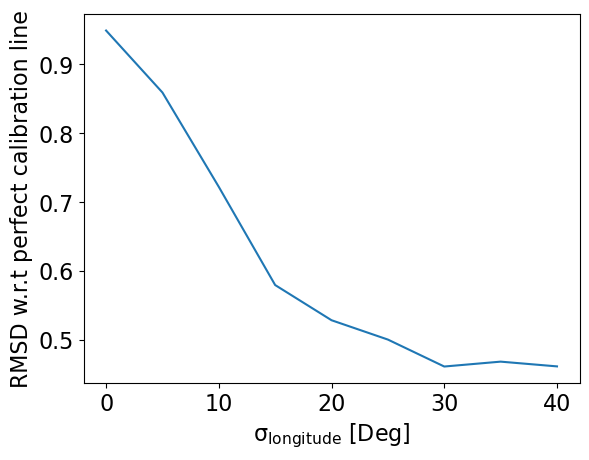

In [537]:
plt.plot(long_dev_list, rmsd_across_long)
plt.xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]')
plt.ylabel('RMSD w.r.t perfect calibration line')
plt.show()

In [539]:
# Enesmble data parameters
key = 'min'
lat_dev = 5
long_dev = 5
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_low_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

# Enesmble data parameters
key = 'min'
lat_dev = 40
long_dev = 40
ensemble_size = 100
event_threshold = 500

# Compute calibration curve
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_high_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 0
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_no_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)


# Enesmble data parameters
key = 'min'
lat_dev = 0
long_dev = 20
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_no_lat_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

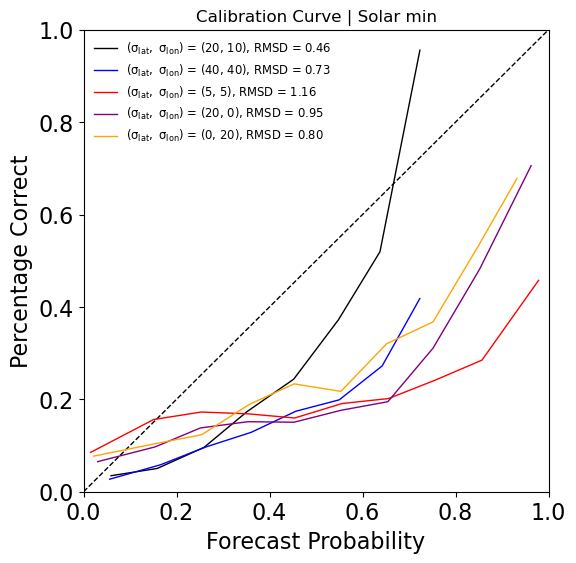

In [541]:
plt.figure(figsize = (6,6))
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.plot(cal_curve[1], cal_curve[0], color = 'black', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({20}, {10}), RMSD = {rmsd_of_cal_curve(cal_curve):.2f}')

plt.plot(cal_curve_high_pert[1], cal_curve_high_pert[0], color = 'blue', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({40}, {40}), RMSD = {rmsd_of_cal_curve(cal_curve_high_pert):.2f}')

plt.plot(cal_curve_low_pert[1], cal_curve_low_pert[0], color = 'red', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({5}, {5}), RMSD = {rmsd_of_cal_curve(cal_curve_low_pert):.2f}')

plt.plot(cal_curve_no_pert[1], cal_curve_no_pert[0], color = 'purple', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({20}, {0}), RMSD = {rmsd_of_cal_curve(cal_curve_no_pert):.2f}')


plt.plot(cal_curve_no_lat_pert[1], cal_curve_no_lat_pert[0], color = 'orange', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({0}, {20}), RMSD = {rmsd_of_cal_curve(cal_curve_no_lat_pert):.2f}')

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()
plt.ylabel('Percentage Correct')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar min')
plt.legend(frameon = False, fontsize = 'small')

fname = 'Calibration_Curves.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
#plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

In [ ]:
key = 'min'

long_dev_list = [0,5,10,15,20,25,30,35,40]
lat_dev_list = [0,5,10,15,20,25,30,35,40]

event_threshold = 500
ensemble_size = 100

briers_grid = []
ROC_grid = []

calibration_curves_grid = []

CR_chunk = solar_era_dict[key]

for lat_dev in lat_dev_list:

    cal_curves_across_long = []
    for long_dev in long_dev_list:

        ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                    omni_data = omni_data, ensemble_size=ensemble_size)

        cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)
        cal_curves_across_long.append(cal_curve)

    calibration_curves_grid.append(cal_curves_across_long)


In [ ]:

obs_freq, pred_freq = zip(*[(tup[0], tup[1]) for sublist in calibration_curves_grid for tup in sublist])

obs_freq_flat = [item for sublist in obs_freq for item in sublist]
pred_freq_flat = [item for sublist in pred_freq for item in sublist]


In [ ]:
hist = plt.hist2d(pred_freq_flat, obs_freq_flat, bins = 10, cmap = 'Greys', alpha = 0.7, label = 'All ensembles')

plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.plot(calibration_curves_grid[4][3][1], calibration_curves_grid[4][3][0], marker = 'x', color = 'red', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[4]}, {long_dev_list[3]})')

plt.plot(calibration_curves_grid[1][1][1], calibration_curves_grid[1][1][0], marker = 'x', color = 'darkblue', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[1]}, {long_dev_list[1]})')

plt.plot(calibration_curves_grid[8][8][1], calibration_curves_grid[8][8][0], marker = 'x', color = 'purple', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[8]}, {long_dev_list[8]})')


plt.colorbar()
plt.ylabel('Observed Frequency')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar {key}')
plt.legend(frameon = False, fontsize = 'small')

plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

#### Briers score and ROC score evaluation

In [ ]:
key = 'min'
lat_dev = 15
long_dev_list = [0,5,10,15,20,25,30,35,40]
event_threshold = 500
probability_threshold = 0.5
ensemble_size = 100

briers_scores_list = []
ROC_scores_list = []

for long_dev in long_dev_list:

    CR_chunk = solar_era_dict[key]
    ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                   omni_data = omni_data, ensemble_size=ensemble_size)
    
    briers_scores_list.append(eef.compute_brier_score_probabilistic(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                                                    threshold=event_threshold, ensemble_size=ensemble_size))
        
    roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                    threshold_range=(200,800), threshold_num=30, probability_threshold = probability_threshold)

    ROC_scores_list.append(compute_roc_score(roc_curve=roc_curve))

In [428]:
key = 'min'

long_dev_list = [0,5,10,15,20,25,30,35,40]
lat_dev_list = [0,5,10,15,20,25,30,35,40]

event_threshold = 500
probability_threshold = 0.5
ensemble_size = 100

briers_grid = []
ROC_grid = []

for lat_dev in lat_dev_list:

    #initialise lists to store briers score + roc score across sigma_long
    temp_briers_scores_list = []
    temp_ROC_scores_list = []

    for long_dev in long_dev_list:

        CR_chunk = solar_era_dict[key]
        ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                    omni_data = omni_data, ensemble_size=ensemble_size)
        
        temp_briers_scores_list.append(eef.compute_brier_score_probabilistic(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                                                        threshold=event_threshold, ensemble_size=ensemble_size))
            
        roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                        threshold_range=(200,800), threshold_num=30, probability_threshold = probability_threshold)

        temp_ROC_scores_list.append(compute_roc_score(roc_curve=roc_curve))

    briers_grid.append(temp_briers_scores_list)
    ROC_grid.append(temp_ROC_scores_list)

In [429]:
save_brier_scores_to_file(briers_grid, era_key='min', event_threshold=event_threshold)
save_roc_scores_to_file(ROC_grid, era_key='min', prob_thresh=probability_threshold)

In [430]:
event_threshold = 500
probability_threshold = 0.5
ensemble_size = 100

briers_grids = [read_brier_scores_file(key, event_threshold) for key in ['min']]
ROC_grids = [read_ROC_scores_file(key, probability_threshold) for key in ['min']]

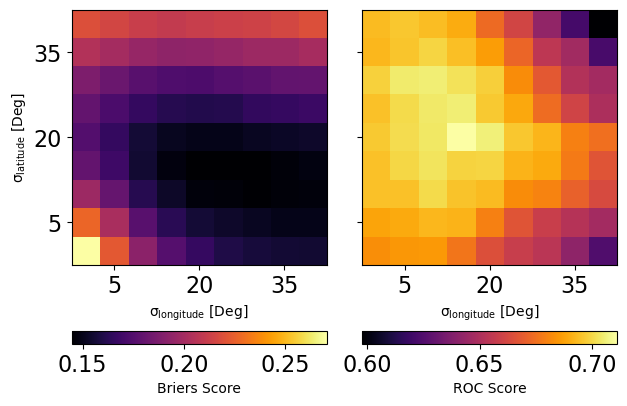

In [432]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = True)

axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

im1 = axes[0].imshow(briers_grids[0], cmap='inferno', origin = 'lower') 
im2 = axes[1].imshow(ROC_grids[0], cmap='inferno', origin = 'lower') 


axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.15, orientation = 'horizontal', aspect = 20) #, anchor = (-2,-2), aspect = 30)  
cbar1.set_label(f'Briers Score', fontsize = 'medium')

cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.15, orientation = 'horizontal', aspect = 20) #, anchor = (-2,-2), aspect = 30)  
cbar2.set_label(f'ROC Score', fontsize = 'medium')

plt.tight_layout()

# fname = 'Briers_ROC_grids_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')


plt.show()

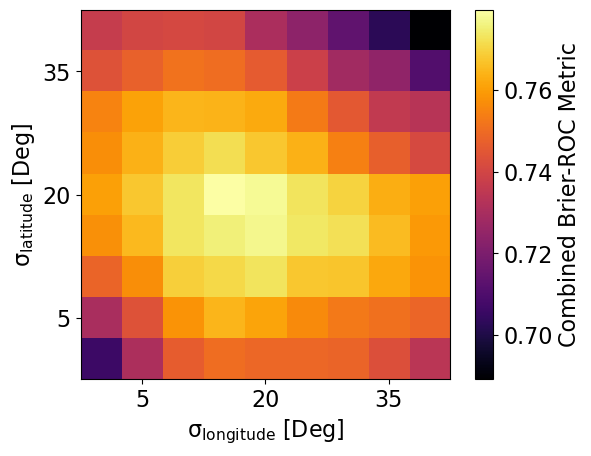

In [433]:
combined_skill_metric = ((1 - briers_grids[0]) + ROC_grids[0])/2

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

fig, ax = plt.subplots(1,1)

im = ax.imshow(combined_skill_metric, cmap='inferno', origin = 'lower') 

ax.set_yticks(np.arange(len(lat_dev_list))[1::3])
ax.set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]')
ax.set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

ax.set_xticks(np.arange(len(long_dev_list))[1::3])
ax.set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]')
ax.set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

cbar = fig.colorbar(im)
cbar.set_label('Combined Brier-ROC Metric')

plt.show()

In [434]:
# Empty lists to store 
scores_within_bounds_BS = []
scores_out_bounds_BS = []

scores_within_bounds_ROC = []
scores_out_bounds_ROC = []

# Get rank histogram/briers/rank grids
rank_hist = rank_histogram_grids[0]
brier_grid = briers_grids[0]
ROC_grid = ROC_grids[0]
CR_chunk = solar_era_dict['min']

## Briers Score Distribution Separation
grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

scores_within_bounds_BS.append(brier_grid[within_percentile_of_min])
scores_out_bounds_BS.append(brier_grid[~within_percentile_of_min])

scores_within_bounds_BS = np.concatenate(scores_within_bounds_BS)
scores_out_bounds_BS = np.concatenate(scores_out_bounds_BS)

## ROC Score distribution separation
grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

scores_within_bounds_ROC.append(ROC_grid[within_percentile_of_min])
scores_out_bounds_ROC.append(ROC_grid[~within_percentile_of_min])

scores_within_bounds_ROC = np.concatenate(scores_within_bounds_ROC)
scores_out_bounds_ROC = np.concatenate(scores_out_bounds_ROC)


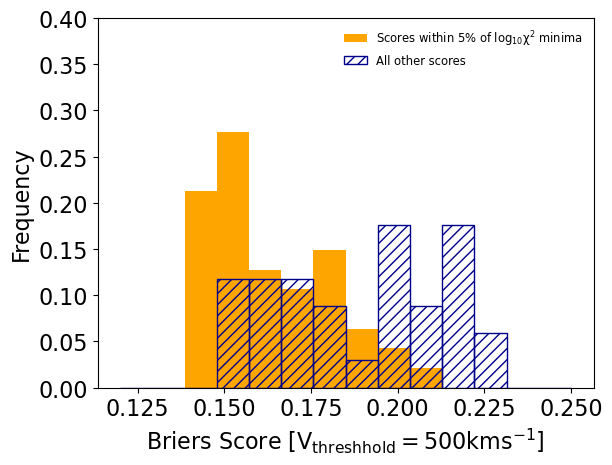

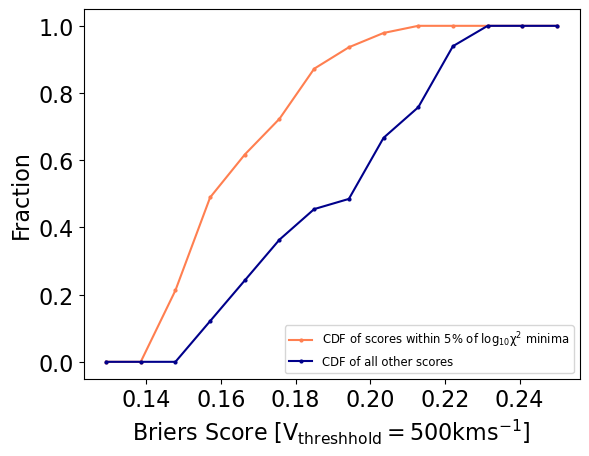

In [437]:
bins = np.linspace(0.12,0.25,15)

plt.hist(scores_within_bounds_BS, label = r'Scores within 5% of $\mathrm{\log_{10}{\chi^2}}$ minima', 
         weights=np.ones(len(scores_within_bounds_BS))/len(scores_within_bounds_BS), bins = bins, color = 'orange')
plt.hist(scores_out_bounds_BS, label = 'All other scores', weights=np.ones(len(scores_out_bounds_BS))/len(scores_out_bounds_BS), 
         bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')

plt.legend(frameon = False, fontsize = 'small')
plt.xlabel(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')
plt.ylabel('Frequency')
plt.ylim(0, 0.4)

# fname = 'Briers_HIST_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

### Computing CDF for briers scores within/without briers minima bounds
hist_1, bin_edges_1 = np.histogram(scores_within_bounds_BS, bins = bins, normed = True)
dx1 = bin_edges_1[1] - bin_edges_1[0]
F1 = np.cumsum(hist_1)*dx1

hist_2, bin_edges_2 = np.histogram(scores_out_bounds_BS, bins = bins, normed = True)
dx2 = bin_edges_2[1] - bin_edges_2[0]
F2 = np.cumsum(hist_2)*dx2

hist_tot, bin_edges_tot = np.histogram(briers_grids[0], bins = bins, normed = True)
dx_tot = bin_edges_tot[1] - bin_edges_tot[0]
Ftot = np.cumsum(hist_tot)*dx_tot

plt.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = r'CDF of scores within 5% of $\mathrm{\log_{10}{\chi^2}}$ minima', color = 'coral')
plt.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = r'CDF of all other scores', color = 'darkblue')
plt.legend(fontsize = 'small')
plt.xlabel(f'Briers Score [$\mathrm{{V_{{threshhold}} = {event_threshold}kms^{{-1}}}}$]')
plt.ylabel('Fraction')

# fname = 'Briers_CDF_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

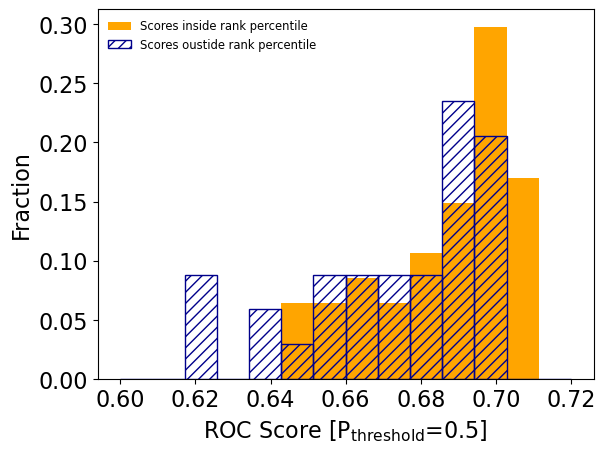

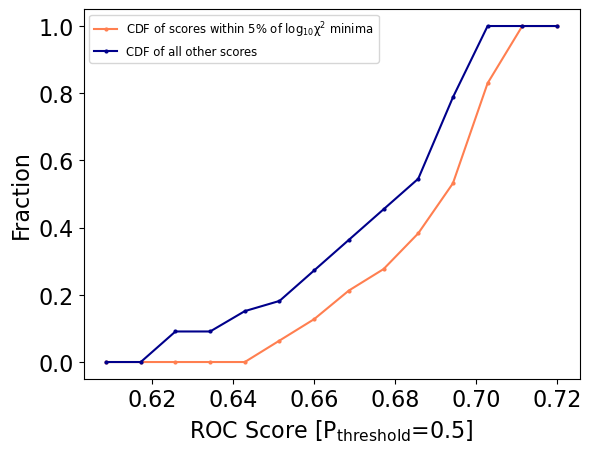

In [439]:
bins = np.linspace(0.6,0.72,15)
plt.hist(scores_within_bounds_ROC, label = 'Scores inside rank percentile', 
         weights=np.ones(len(scores_within_bounds_ROC))/len(scores_within_bounds_ROC), bins = bins, color = 'orange')
plt.hist(scores_out_bounds_ROC, label = 'Scores oustide rank percentile', 
         weights=np.ones(len(scores_out_bounds_ROC))/len(scores_out_bounds_ROC), bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')
plt.legend(frameon = False, fontsize = 'small')
plt.xlabel(f'ROC Score [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')
plt.ylabel('Fraction')

# fname = 'ROC_HIST_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

### Computing CDF for briers scores within/without briers minima bounds
hist_1, bin_edges_1 = np.histogram(scores_within_bounds_ROC, bins = bins, normed = True)
dx = bin_edges_1[1] - bin_edges_1[0]
F1 = np.cumsum(hist_1)*dx

hist_2, bin_edges_2 = np.histogram(scores_out_bounds_ROC, bins = bins, normed = True)
dx = bin_edges_2[1] - bin_edges_2[0]
F2 = np.cumsum(hist_2)*dx

plt.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = r'CDF of scores within 5% of $\mathrm{\log_{10}{\chi^2}}$ minima', color = 'coral')
plt.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = r'CDF of all other scores', color = 'darkblue')
plt.legend(fontsize = 'small')
plt.xlabel(f'ROC Score [$\mathrm{{P_{{threshold}}}}$={probability_threshold}]')
plt.ylabel('Fraction')

# fname = 'ROC_CDF_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

In [574]:
def generate_recurrence(CR_chunk, omni_data):

    forecast_window = 27.2753*u.day
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(forecast_window.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frames into single frame
    combined_data = pd.concat(data_chunks)

    ## Define carrington rotation offset for index
    carrington_rotation = pd.Timedelta(27.25, unit = 'days')
    omni_data_reccurance = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

    # Isolate data within forecast range + backward additional month needed for 1st carrington rotations of forecast
    omni_data_reccurance = omni_data_reccurance.loc[(combined_data.index[0]-carrington_rotation):(combined_data.index[-1])]

    # Grab index from isolated reccurence data set (combined_data index) 
    omni_data_index = omni_data_reccurance.index

    # Project index forward by 1 carrington rotation
    reccurance_forecast_index = omni_data_index + carrington_rotation

    # Set index for reccurent forecast to the new forward projected datetime series
    reccurance_forecast = omni_data_reccurance.set_index(reccurance_forecast_index)
    reccurance_forecast = reccurance_forecast.loc[pd.to_datetime(combined_data.index[0]):pd.to_datetime(combined_data.index[-1])]

    return reccurance_forecast, omni_data.loc[(combined_data.index[0]):combined_data.index[-1]]

In [575]:
recurrance_chunks = []
era_data_chunks = []

for CR_chunk in solar_min_list:
    rec_forecast, data_chunk = generate_recurrence(CR_chunk=CR_chunk, omni_data=omni_data)
    recurrance_chunks.append(rec_forecast)
    era_data_chunks.append(data_chunk)

recurrance_forecast = pd.concat(recurrance_chunks)
solar_min_data = pd.concat(era_data_chunks)


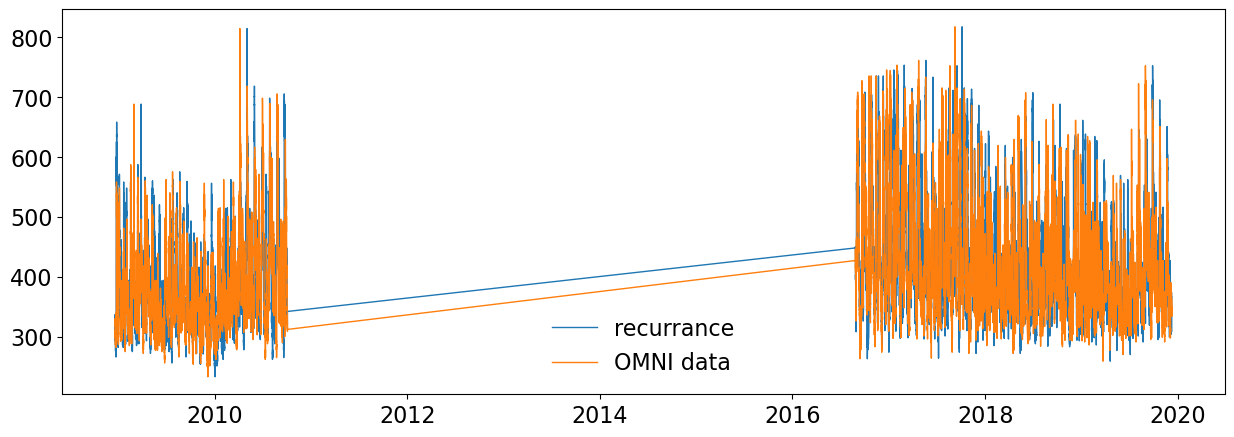

In [576]:
plt.figure(figsize=(15,5))
plt.plot(recurrance_forecast['V'], lw = 1, label = 'recurrance')
plt.plot(solar_min_data['V'], lw = 1, label = 'OMNI data')
plt.legend(frameon = False)
plt.show()

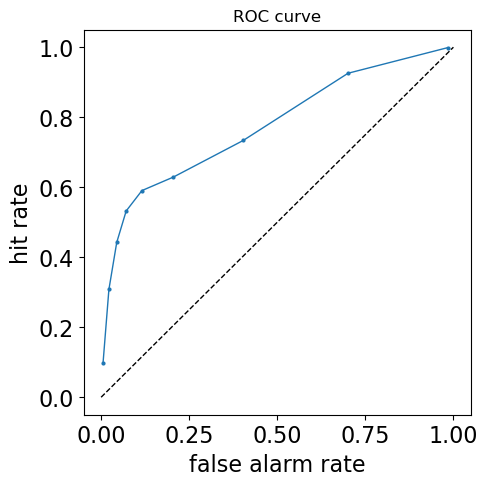

In [594]:
roc_curve_recurrence = eef.generate_roc_curve(forecast=recurrance_forecast['V'].to_numpy(), observed_data=solar_min_data['V'], threshold_range=(200,700), threshold_num=10)
eef.plot_roc_curve(roc_curve_recurrence)

### Cost Loss

In [453]:
# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 15
ensemble_size = 100
event_threshold = 500

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)


In [442]:
# Read in deterministic HUXt output
key = 'min'
CR_chunk = solar_era_dict[key]

deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in CR_chunk]
data_chunks = get_data_chunks_per_CR(CR_chunk=CR_chunk, omni_data = omni_data)

# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_chunks[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = observed_data.index)

In [454]:
action_threshold = 500
probability_threshold = 0.5

probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=action_threshold, ensemble_size=ensemble_size)
action_threshold_data = observed_data['V'] > action_threshold


In [578]:
def finding_cost_loss(actual_events, forecasted_probabilities, threshold):
    """
    Finding costs and loss based on an action threshold.

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    forecasted_probabilities (array): List of forecasted probabilities for events.
    threshold (float): Threshold for action.

    Returns:
    dict: Dictionary containing counts for correct forecasts, incorrect forecasts, and missed events.
    """
    correct_forecasts = 0
    incorrect_forecasts = 0
    missed_events = 0

    for actual, probability in zip(actual_events, forecasted_probabilities):
        if actual and probability >= threshold: # correctly forecast event (incurring a cost)
            correct_forecasts += 1
        elif not actual and probability >= threshold: # incoreectly forecast event (incurring a cost)
            incorrect_forecasts += 1
        elif actual and probability < threshold: # missing an event (incurring a loss)
            missed_events += 1
    
    return {'correct_costs': correct_forecasts, 'incorrect_costs': incorrect_forecasts, 'loss': missed_events}


def calculate_potential_economic_value(actual_events, costs, losses, cost_loss_ratio):

    """
    Finding potenial economic value

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    costs (float): number of costs
    losses (float): number of losses
    cost_loss_ratio (float): cost loss ratio for computing potential economic value

    Returns:
    V: potential economic value
    """
        
    climatology_prob = np.mean(actual_events.to_numpy())
    perfect_cost = np.sum(actual_events)

    # climatological cost changes if climatological prob is above/below c/l ratio 
    if cost_loss_ratio <= climatology_prob: # always take action

        climatological_cost = len(actual_events)
        climatological_expense = climatological_cost*cost_loss_ratio
    
        #climatological_expense = len(action_threshold_data)*cost_loss_ratio

    elif cost_loss_ratio > climatology_prob: # never take action

        climatological_loss = perfect_cost
        climatological_expense = climatological_loss

    # forecast expense
    forecast_expense = costs*cost_loss_ratio + losses

    # potential economic value
    V = 100 * (climatological_expense - forecast_expense)/(climatological_expense - perfect_cost*cost_loss_ratio)

    return V



In [579]:
action_threshold = 550
probability_threshold = 0.2
probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=action_threshold, ensemble_size=ensemble_size)
action_threshold_data = observed_data['V'] > action_threshold

ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = 0.2)
deterministic_cost_loss = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=deterministic_forecast['vsw'] > action_threshold, threshold=1)



calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                   losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = 0.2)

-48.78142076502734

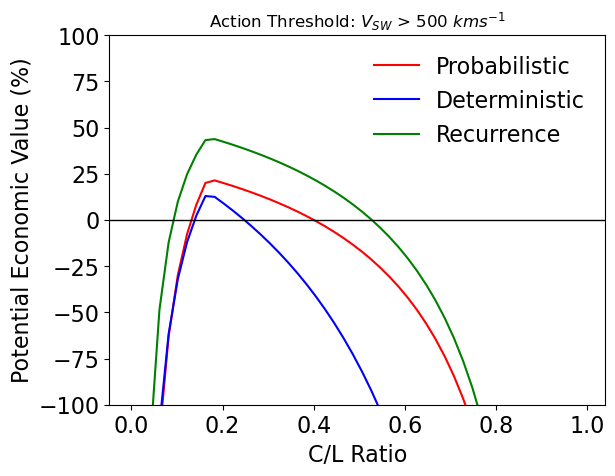

In [592]:
cost_loss_ratios = np.linspace(0.001,0.99,50)
action_threshold = 500
prob_thresh = 0.5
probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=action_threshold, ensemble_size=ensemble_size)
action_threshold_data = observed_data['V'] > action_threshold

PEV_list = []
PEV_list_det = []
PEV_list_rec = []

deterministic_cost_loss = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=deterministic_forecast['vsw'] > action_threshold, threshold=1)
recurrence_cost_loss = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=recurrance_forecast['V'] > action_threshold, threshold=1)


for cl in cost_loss_ratios:
    
    
    #prob_thresh = cl

    ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
    PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                   losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
    
    PEV_list_det.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = deterministic_cost_loss['correct_costs'] + deterministic_cost_loss['incorrect_costs'],
                                   losses = deterministic_cost_loss['loss'], cost_loss_ratio = cl))
    
        
    PEV_list_rec.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = recurrence_cost_loss['correct_costs'] + recurrence_cost_loss['incorrect_costs'],
                                   losses = recurrence_cost_loss['loss'], cost_loss_ratio = cl))


plt.plot(cost_loss_ratios, PEV_list, label = 'Probabilistic', color = 'red')
plt.plot(cost_loss_ratios, PEV_list_det, label = 'Deterministic', color = 'blue')
plt.plot(cost_loss_ratios, PEV_list_rec, label = 'Recurrence', color = 'green')

plt.xlabel('C/L Ratio')
plt.ylabel('Potential Economic Value (%)')
plt.title(f'Action Threshold: $V_{{SW}}$ > {action_threshold} $kms^{{-1}}$')
plt.legend(frameon = False)
plt.axhline(0, lw = 1, color = 'black')
plt.ylim(-100,100)

plt.show()

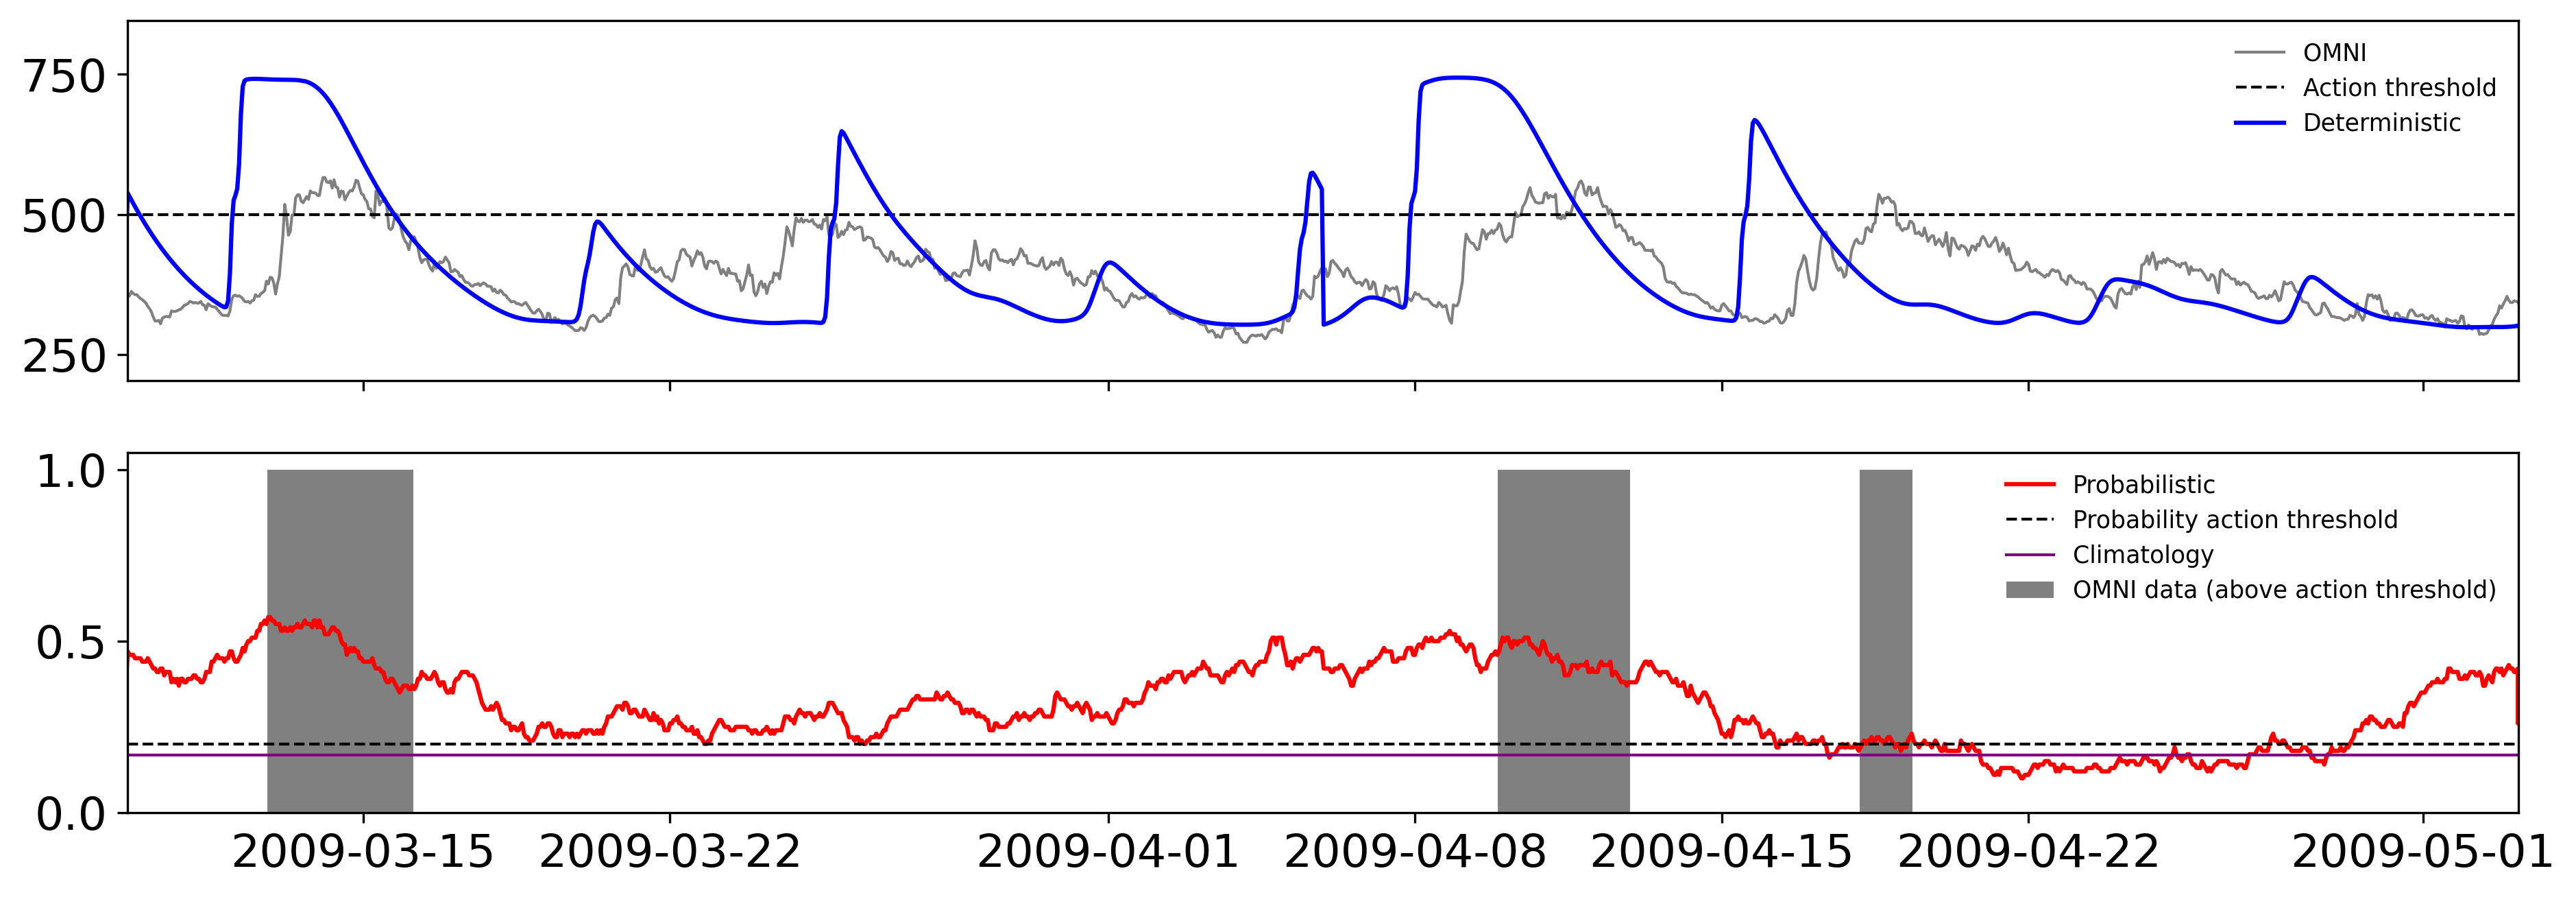

In [587]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (15,5), dpi = 300, sharex = True)

forecast_window = 27.2753*u.day
CR = 2081
CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
CR_end = CR_start + pd.Timedelta((forecast_window*2).value, unit = 'days')

axes[0].plot(observed_data['V'], lw = 1, color = 'grey', label = 'OMNI')
axes[0].axhline(action_threshold, lw = 1, linestyle = '--', color = 'black', label = 'Action threshold')
axes[0].plot(deterministic_forecast['vsw'], color = 'blue', label = 'Deterministic')


axes[1].bar(action_threshold_data.index, action_threshold_data.to_numpy(), color = 'grey', label = 'OMNI data (above action threshold)')
axes[1].plot(observed_data.index, probabilistic_forecast, color = 'red', label = 'Probabilistic')
axes[1].axhline(probability_threshold, linestyle = '--', lw = 1, color = 'black', label = 'Probability action threshold')
axes[1].axhline(np.mean(action_threshold_data.to_numpy()), lw = 1, color = 'purple', label = 'Climatology')
axes[0].legend(frameon = False, fontsize = 'small')
axes[1].legend(frameon = False, fontsize = 'small')

plt.xlim(CR_start, CR_end)

plt.show()
